In [1]:
import torch as tc
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import random

import pandas as pd
import numpy as np

from functions import LMF, MF, NMF, PMF, ALS, recommend_movies, topK

In [2]:
# pass in column names for each CSV
u_cols = ['User_ID', 'Age', 'Sex', 'Occupation', 'Zip_Code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')
users = users.drop(columns=['Zip_Code'])

r_cols = ['User_ID', 'Movie_ID', 'Rating', 'Timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')
ratings = ratings.drop(columns=['Timestamp'])

m_cols = ['Movie_ID', 'Title', 'Release_Date', 'Video_Release_Date', 'Imdb_URL']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5), encoding='latin-1')
movies = movies.drop(columns=['Video_Release_Date', 'Imdb_URL'])

## Create R Matrix and Mask Matrix

In [3]:
test_size = 0.5
train_df, test_df = train_test_split(ratings, test_size=test_size)
train = train_df.values
test = test_df.values

M = max(max(train[:,0]),max(test[:,0]))
N = max(max(train[:,1]),max(test[:,1]))


R = np.zeros((M, N))
num = train.shape[0]
for i in range(num):
    R[train[i,0]-1,train[i,1]-1]=train[i,2]
    
R_test = np.zeros((M, N))
num = test.shape[0]
for i in range(num):
    R_test[test[i,0]-1,test[i,1]-1]=test[i,2]
    
test_samples = [
            (i, j, R_test[i, j])
            for i in range(M)
            for j in range(N)
            if R_test[i, j] > 0
        ]
test = np.array(test_samples)

R_nan = R.copy()
R_nan[R_nan==0] = np.nan

In [4]:
R_df = ratings.pivot(index = 'User_ID', columns ='Movie_ID', values = 'Rating').fillna(0)
R_nan_df = ratings.pivot(index = 'User_ID', columns ='Movie_ID', values = 'Rating')
#R = R_df.values
#R_nan = R_nan_df.values
M, N = R.shape
mask = np.ones((M, N))
present = np.ma.masked_where(R != 0, R)
mask[present.mask == False] = False
mask_test = np.ones((M, N))
present_test = np.ma.masked_where(R_test != 0, R_test)
mask_test[present_test.mask == False] = False

mask_tc = tc.Tensor(mask)
R_tc = tc.Tensor(R)
R_normalized = (R - 1) / 4
R_normalized[mask==False] = 0
R_normalized_tc = tc.Tensor(R_normalized)

b = np.nanmean(R_nan)
b_u = np.nanmean(R_nan - b, axis = 1).reshape(M,1)
b_u[np.isnan(b_u)] = 0
b_i = np.nanmean(R_nan - b, axis = 0).reshape(1,N)
b_i[np.isnan(b_i)]=0
bias = b + b_u + b_i

R_bias = mask * (R - bias)
R_bias_tc = tc.Tensor(R_bias)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


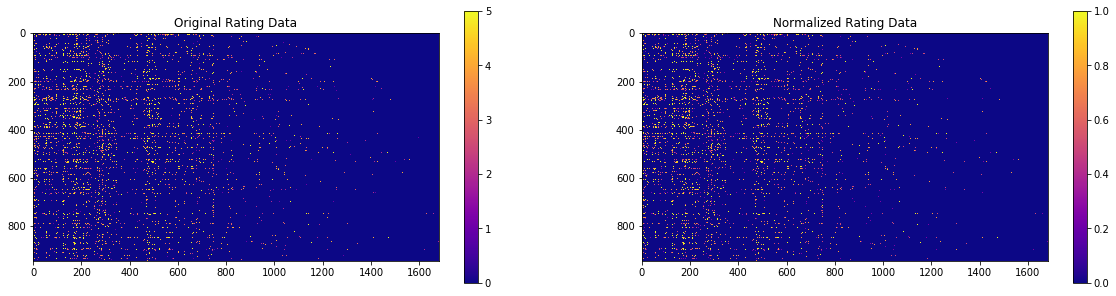

In [5]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(R, cmap='plasma',vmax=5,vmin=0)
plt.title('Original Rating Data')
plt.colorbar()
plt.subplot(122)
plt.imshow(R_normalized, cmap='plasma', vmax=1,vmin=0)  
plt.title('Normalized Rating Data')
plt.colorbar()
plt.show()

## Logistic Matrix Factorization

In [6]:
rank = 30
lmf = LMF(R_normalized_tc, mask_tc, rank, eta=0.005, nu=0.1, momentum=0.9, MAX_ITER=2000)
lmf.train()

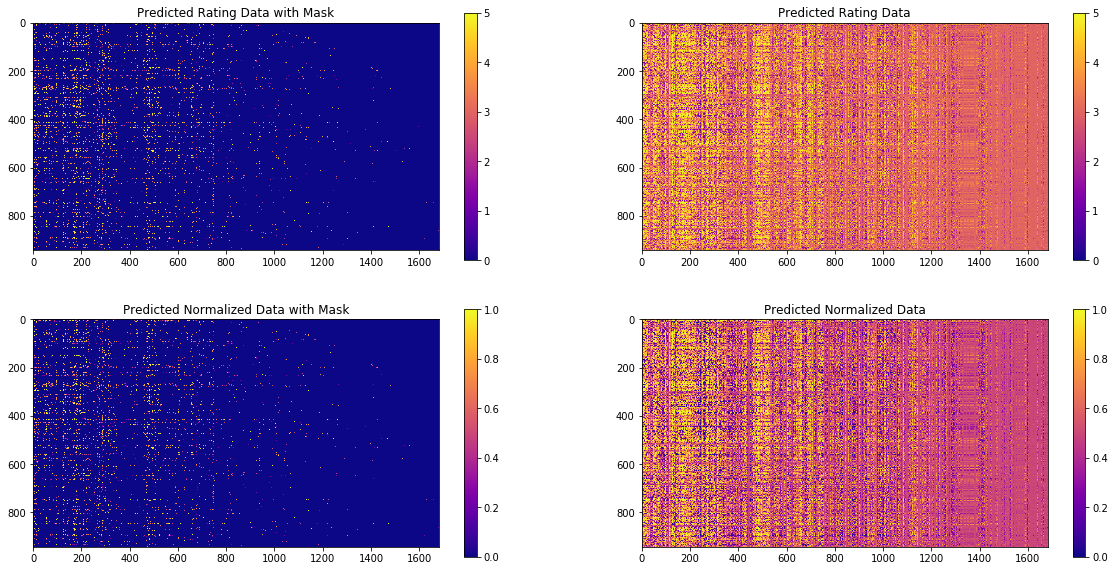

RMSE Error
1.4543317122154396
precision_acc,recall_acc:(0.1037115588547191, 0.21470377840919008)
User 837 has already rated 46 movies.
Recommending the highest 10 predicted ratings movies not already rated.


Movie_ID                            Title Release_Date
40         48               Hoop Dreams (1994)  01-Jan-1994
11         14               Postino, Il (1994)  01-Jan-1994
175       187   Godfather: Part II, The (1974)  01-Jan-1974
63         71            Lion King, The (1994)  01-Jan-1994
10         12       Usual Suspects, The (1995)  14-Aug-1995
179       191                   Amadeus (1984)  01-Jan-1984
163       174   Raiders of the Lost Ark (1981)  01-Jan-1981
161       172  Empire Strikes Back, The (1980)  01-Jan-1980
283       313                   Titanic (1997)  01-Jan-1997
162       173       Princess Bride, The (1987)  01-Jan-1987

In [7]:
normalized_pred_tc = lmf.prediction
normalized_prediction = normalized_pred_tc.detach().numpy()
masked_normalized_prediction = mask * normalized_prediction
prediction = 4 * normalized_prediction + 1
masked_prediction = mask * prediction

plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(223)
plt.imshow(masked_normalized_prediction, cmap='plasma',vmax=1,vmin=0)  
plt.title('Predicted Normalized Data with Mask')
plt.colorbar()

plt.subplot(222)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.subplot(224)
plt.imshow(normalized_prediction, cmap='plasma',vmax=1,vmin=0)  
plt.title('Predicted Normalized Data')
plt.colorbar()
plt.show()

E = R_test - mask_test*prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)/(100000*test_size)))
print("precision_acc,recall_acc:" + str(topK(prediction,test)))

prediction_df = pd.DataFrame(prediction, columns = R_df.columns)
already_rated, predictions = recommend_movies(prediction_df, 837, movies, ratings, 10)
predictions

## Matrix Factorization

In [8]:
rank = 30
mf = MF(R_bias_tc, mask_tc, rank, eta=0.001, nu=0.1, momentum=0.9, MAX_ITER=2000)
mf.train()

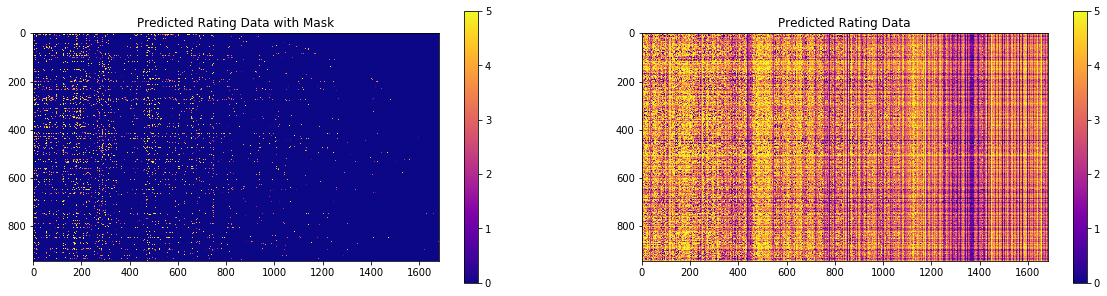

RMSE Error
1.6897160778541134
precision_acc,recall_acc:(0.0754294803817604, 0.13581216870031493)
User 837 has already rated 46 movies.
Recommending the highest 10 predicted ratings movies not already rated.


Movie_ID                                           Title Release_Date
548       582                               Piano, The (1993)  01-Jan-1993
101       109  Mystery Science Theater 3000: The Movie (1996)  19-Apr-1996
17         24                      Rumble in the Bronx (1995)  23-Feb-1996
377       408                           Close Shave, A (1995)  28-Apr-1996
167       178                             12 Angry Men (1957)  01-Jan-1957
568       603                              Rear Window (1954)  01-Jan-1954
140       150                                 Swingers (1996)  18-Oct-1996
232       248                      Grosse Pointe Blank (1997)  11-Apr-1997
170       182                               GoodFellas (1990)  01-Jan-1990
679       715                               To Die For (1995)  01-Jan-1995

In [9]:
prediction_tc = mf.prediction
prediction = prediction_tc.detach().numpy() + bias
masked_prediction = mask * prediction

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.show()

E = R_test - mask_test*prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)/(100000*test_size)))
print("precision_acc,recall_acc:" + str(topK(prediction,test)))

prediction_df = pd.DataFrame(prediction, columns = R_df.columns)
already_rated, predictions = recommend_movies(prediction_df, 837, movies, ratings, 10)
predictions

## Probabilistic Matrix Factorization

In [11]:
R_samples = [
            (i, j, R[i, j])
            for i in range(M)
            for j in range(N)
            if R[i, j] > 0
        ]
R_samples = np.array(R_samples)

#R_samples = [
#            (i, j, R_bias[i, j])
#            for i in range(M)
#            for j in range(N)
#            if R_bias[i, j] != 0
#        ]
#R_samples = np.array(R_samples)

In [12]:
pmf = PMF()
pmf.set_params({"num_feat": 30, "epsilon": 1, "_lambda": 0.1, "momentum": 0.9, "maxepoch": 50, "num_batches": 200, "batch_size": 5000})
#train, test = train_test_split(R_samples, test_size=0.2)
pmf.train(R_samples, test)

Training RMSE: 1.053292, Test RMSE 1.113049
Training RMSE: 0.821195, Test RMSE 1.016454
Training RMSE: 0.679868, Test RMSE 1.001116
Training RMSE: 0.589996, Test RMSE 1.008532
Training RMSE: 0.533075, Test RMSE 1.017323
Training RMSE: 0.496282, Test RMSE 1.024068
Training RMSE: 0.471404, Test RMSE 1.028966
Training RMSE: 0.453790, Test RMSE 1.032506
Training RMSE: 0.440799, Test RMSE 1.035131
Training RMSE: 0.430849, Test RMSE 1.037104
Training RMSE: 0.422996, Test RMSE 1.038655
Training RMSE: 0.416633, Test RMSE 1.039859
Training RMSE: 0.411421, Test RMSE 1.040751
Training RMSE: 0.407010, Test RMSE 1.041510
Training RMSE: 0.403301, Test RMSE 1.042068
Training RMSE: 0.400081, Test RMSE 1.042544
Training RMSE: 0.397309, Test RMSE 1.042869
Training RMSE: 0.394838, Test RMSE 1.043167
Training RMSE: 0.392676, Test RMSE 1.043371
Training RMSE: 0.390733, Test RMSE 1.043545
Training RMSE: 0.388993, Test RMSE 1.043662
Training RMSE: 0.387416, Test RMSE 1.043756
Training RMSE: 0.385989, Test RM

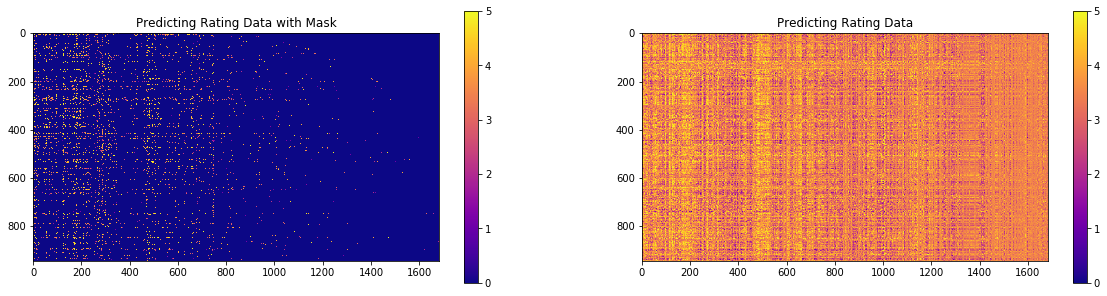

RMSE Error
1.0436033967042904
precision_acc,recall_acc:(0.07166489925768818, 0.1397205611921011)


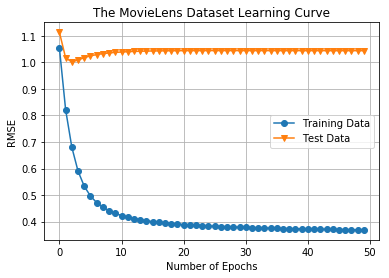

User 837 has already rated 46 movies.
Recommending the highest 10 predicted ratings movies not already rated.


Movie_ID                                              Title Release_Date
431        462  Like Water For Chocolate (Como agua para choco...  01-Jan-1992
52          60                          Three Colors: Blue (1993)  01-Jan-1993
1156      1203                                     Top Hat (1935)  01-Jan-1935
455        488                                Sunset Blvd. (1950)  01-Jan-1950
1054      1101                   Six Degrees of Separation (1993)  01-Jan-1993
1105      1152                             In Love and War (1996)  24-Jan-1997
479        512                             Wings of Desire (1987)  01-Jan-1987
627        663                                 Being There (1979)  01-Jan-1979
1269      1316                        Horse Whisperer, The (1998)  25-Dec-1997
26          34                        Doom Generation, The (1995)  01-Jan-1995

In [13]:
prediction = pmf.prediction
masked_prediction = mask * prediction

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicting Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicting Rating Data')
plt.colorbar()
plt.show()

E = R_test - mask_test*prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)/(100000*test_size)))
print("precision_acc,recall_acc:" + str(topK(prediction,test)))

# Check performance by plotting train and test errors
plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

prediction_df = pd.DataFrame(prediction, columns = R_df.columns)
already_rated, predictions = recommend_movies(prediction_df, 837, movies, ratings, 10)
predictions

## Nonnegative Matrix Factorization

In [14]:
rank = 30
nmf = NMF(R, mask, rank, MAX_ITER=3000)
nmf.train()

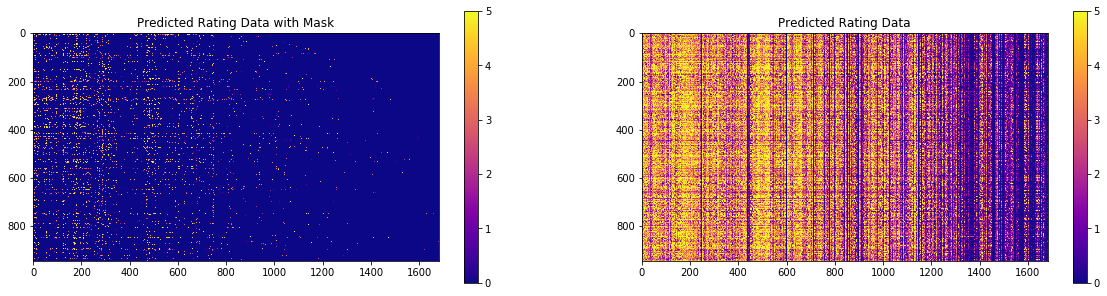

RMSE Error
1.6146450330488258
precision_acc,recall_acc:(0.05839872746553559, 0.10550788831917556)
User 837 has already rated 46 movies.
Recommending the highest 10 predicted ratings movies not already rated.


Movie_ID                               Title Release_Date
942        986                   Turbulence (1997)  10-Jan-1997
62          70  Four Weddings and a Funeral (1994)  01-Jan-1994
321        352                  Spice World (1997)  01-Jan-1997
1379      1426            Grace of My Heart (1996)  13-Sep-1996
242        260                Event Horizon (1997)  01-Jan-1997
1037      1084        Anne Frank Remembered (1995)  23-Feb-1996
168        179          Clockwork Orange, A (1971)  01-Jan-1971
935        979          Trigger Effect, The (1996)  30-Aug-1996
836        877               Excess Baggage (1997)  01-Jan-1997
624        660         Fried Green Tomatoes (1991)  01-Jan-1991

In [15]:
prediction = nmf.prediction
masked_prediction = mask * prediction

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.show()

E = R_test - mask_test*prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)/(100000*test_size)))
print("precision_acc,recall_acc:" + str(topK(prediction,test)))


prediction_df = pd.DataFrame(prediction, columns = R_df.columns)
already_rated, predictions = recommend_movies(prediction_df, 837, movies, ratings, 10)
predictions

## Alternating Least Squares

In [16]:
rank = 30
lambda_ = 0.1
als = ALS(R_bias, mask, rank, lambda_, MAX_ITER=10)
als.train()

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed


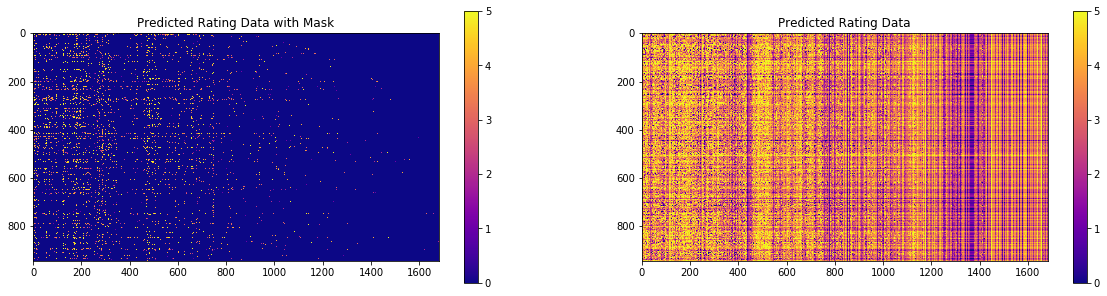

RMSE Error
1.4975692821645745
precision_acc,recall_acc:(0.07453870625662788, 0.14143087907069826)
User 837 has already rated 46 movies.
Recommending the highest 10 predicted ratings movies not already rated.


Movie_ID                                          Title Release_Date
182       194                              Sting, The (1973)  01-Jan-1973
92        100                                   Fargo (1996)  14-Feb-1997
89         97                      Dances with Wolves (1990)  01-Jan-1990
174       186                     Blues Brothers, The (1980)  01-Jan-1980
123       133                      Gone with the Wind (1939)  01-Jan-1939
175       187                 Godfather: Part II, The (1974)  01-Jan-1974
212       227  Star Trek VI: The Undiscovered Country (1991)  01-Jan-1991
258       282                         Time to Kill, A (1996)  13-Jul-1996
994      1039                                  Hamlet (1996)  24-Jan-1997
23         31                            Crimson Tide (1995)  01-Jan-1995

In [17]:
prediction = als.prediction + bias
masked_prediction = mask * prediction

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.show()

E = R_test - mask_test*prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)/(100000*test_size)))
print("precision_acc,recall_acc:" + str(topK(prediction,test)))


prediction_df = pd.DataFrame(prediction, columns = R_df.columns)
already_rated, predictions = recommend_movies(prediction_df, 837, movies, ratings, 10)
predictions

## SVD

In [18]:
U, sigma, Vt = svds(R_bias, k = 30)
sigma = np.diag(sigma)

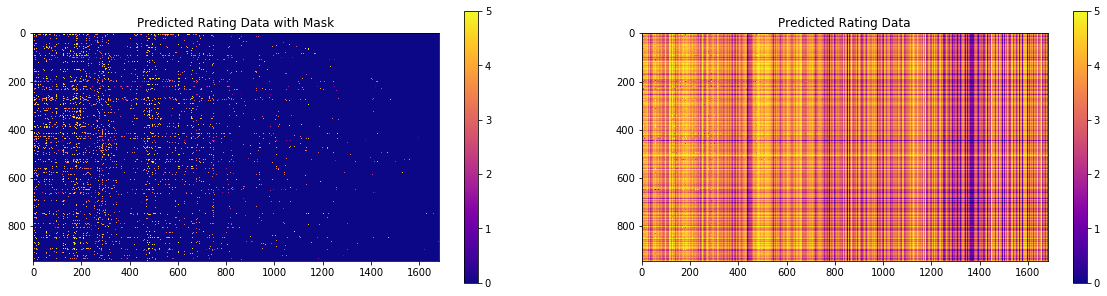

RMSE Error
0.9729231260342264
precision_acc,recall_acc:(0.0625344644750796, 0.12613583174815463)
User 837 has already rated 46 movies.
Recommending the highest 10 predicted ratings movies not already rated.


Movie_ID                                              Title Release_Date
1401      1448                          My Favorite Season (1993)  19-Apr-1996
1609      1656                                 Little City (1998)  20-Feb-1998
1402      1449                             Pather Panchali (1955)  22-Mar-1996
1108      1155  Rendezvous in Paris (Rendez-vous de Paris, Les...  28-Jun-1996
1246      1293                                    Star Kid (1997)  16-Jan-1998
1311      1358                             The Deadly Cure (1996)  16-Sep-1996
1130      1177                           Dunston Checks In (1996)  01-Jan-1996
1547      1594                                     Everest (1998)  10-Mar-1998
1128      1175                                   Hugo Pool (1997)  01-Jan-1997
1142      1189                                 Prefontaine (1997)  24-Jan-1997

In [19]:
prediction = np.dot(np.dot(U, sigma), Vt) + bias
masked_prediction = mask * prediction

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.show()

E = R_test - mask_test*prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)/(100000*test_size)))
print("precision_acc,recall_acc:" + str(topK(prediction,test)))


prediction_df = pd.DataFrame(prediction, columns = R_df.columns)
already_rated, predictions = recommend_movies(prediction_df, 837, movies, ratings, 10)
predictions

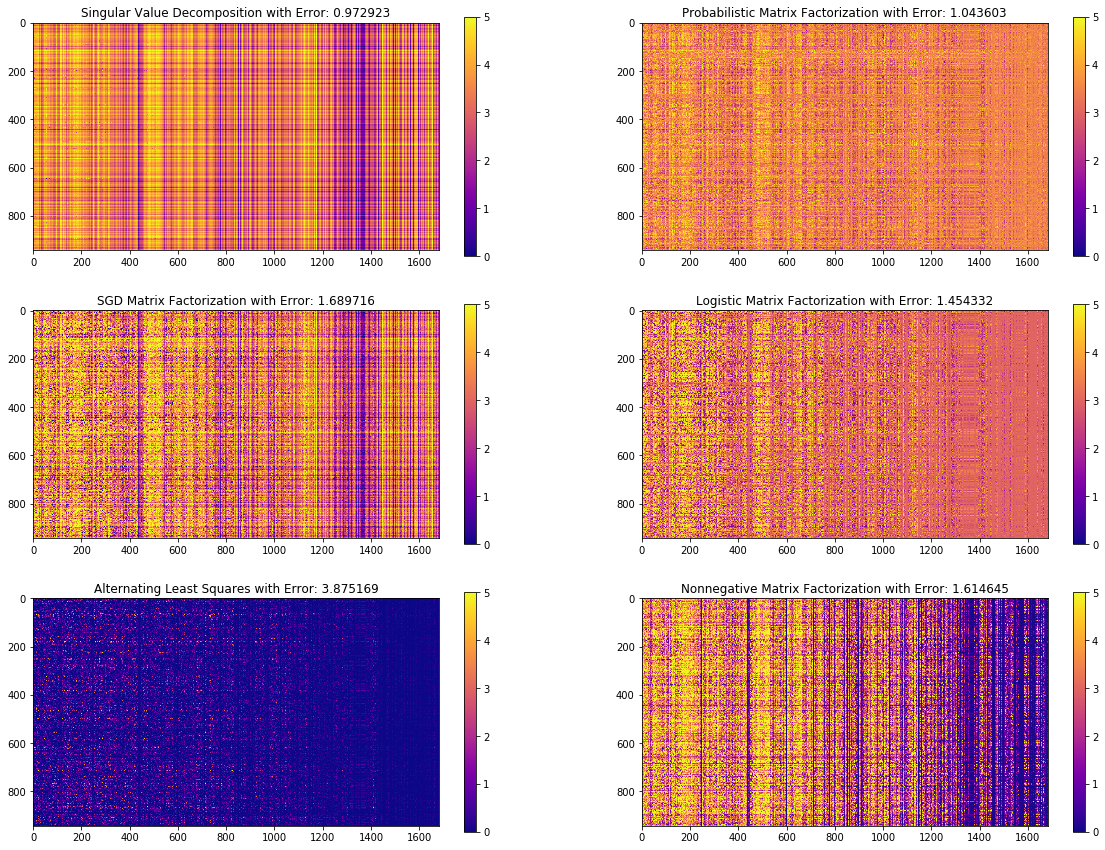

In [20]:
plt.figure(figsize=(20,15))

prediction = np.dot(np.dot(U, sigma), Vt) + bias
p1, r1 = topK(prediction,test)
E = R_test - mask_test * prediction
plt.subplot(321)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Singular Value Decomposition with Error: %f' % (np.sqrt(np.sum(E**2)/(100000*test_size))))
plt.colorbar()

prediction = pmf.prediction
p2, r2 = topK(prediction,test)
E = R_test - mask_test * prediction
plt.subplot(322)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Probabilistic Matrix Factorization with Error: %f'  % (np.sqrt(np.sum(E**2)/(100000*test_size))))
plt.colorbar()

prediction_tc = mf.prediction
prediction = prediction_tc.detach().numpy() + bias
p3, r3 = topK(prediction,test)
E = R_test - mask_test * prediction
plt.subplot(323)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('SGD Matrix Factorization with Error: %f'  % (np.sqrt(np.sum(E**2)/(100000*test_size))))
plt.colorbar()

normalized_pred_tc = lmf.prediction
normalized_prediction = normalized_pred_tc.detach().numpy()
prediction = 4 * normalized_prediction + 1
p4, r4 = topK(prediction,test)
E = R_test - mask_test * prediction
plt.subplot(324)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Logistic Matrix Factorization with Error: %f' % (np.sqrt(np.sum(E**2)/(100000*test_size))))
plt.colorbar()

prediction = als.prediction
p5, r5 = topK(prediction,test)
E = R_test - mask_test * prediction
plt.subplot(325)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Alternating Least Squares with Error: %f' % (np.sqrt(np.sum(E**2)/(100000*test_size))))
plt.colorbar()

prediction = nmf.prediction
p6, r6 = topK(prediction,test)
E = R_test - mask_test * prediction
plt.subplot(326)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Nonnegative Matrix Factorization with Error: %f' % (np.sqrt(np.sum(E**2)/(100000*test_size))))
plt.colorbar()
plt.show()

In [21]:
plt.figure(figsize=(7,8))
plt.imshow(R, cmap='plasma',vmax=5,vmin=0)
plt.title('Original Rating Data')
#plt.colorbar()
plt.show()

In [24]:
N = 6
men_means = (p1, p2, p3, p4, p5, p6)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(ind, men_means, width, color='b')

women_means = (r1, r2, r3, r4, r5, r6)
#women_std = (0, 0, 2, 3, 3)
rects2 = ax.bar(ind + width, women_means, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Precision - Recall Curve')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('SVD', 'PMF', 'MF-SGD', 'LMF', 'ALS', 'NMF'))
ax.set_ylim(0,0.25)

ax.legend((rects1[0], rects2[0]), ('Precision', 'Recall'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.3f' % (height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()